In [2]:
import numpy as np
from functools import reduce
import math
from qiskit import QuantumCircuit, transpile
# from qiskit_algorithms import TrotterQRTE, TimeEvolutionProblem
from qiskit.quantum_info import Statevector
from qiskit.circuit import *
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator
from matplotlib import pyplot as plt
import scipy.linalg as la


service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

In [3]:
def dagger(a):
    return np.transpose(a).conj()

In [4]:
def pretty_print_matrix(matrix):
    print(('\n'.join(['\t'.join([str(cell) for cell in row]) for row in matrix])))

In [5]:
def make_Majorana(N):

    # Make 'N' Majorana fermions. Set of N Hermitian matrices psi_i, i=1,..N
    # obeying anti-commutation relations {psi_i,psi_j} = δ_{ij}
    # Note: Not 2δ_{ij}
    
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.array([[1, 0], [0, 1]])

    psi = dict()

    for i in range(1, N+1):

        if (i % 2) == 1:
            matlist = [Z] * int((i-1)/2)
            matlist.append(X)
            matlist = matlist + [I] * int((N/2 - (i+1)/2))
            psi[i] = 1/np.sqrt(2)*reduce(np.kron, matlist)
        else:
            matlist = [Z] * int((i - 2) / 2)
            matlist.append(Y)
            matlist = matlist + [I] * int((N/2 - i/2))
            psi[i] = 1/np.sqrt(2)*reduce(np.kron, matlist)


    for i in range(1, N+1):
        for j in range(1, N+1):

            if i != j:
                if np.allclose(psi[i] @ psi[j], -psi[j] @ psi[i]) == False:
                    print ("Does not satisfy algebra for i != j")

            if i == j:
                if np.allclose(psi[i] @ psi[j] + psi[j] @ psi[i], np.eye(int(2**(N/2)))) == False:
                    print ("Does not satisfy algebra for i = j")

    return psi

In [6]:
def make_Hamiltonian(psi, N, instances, J_squared):
    
    # Creates multiple realisations of the SYK Hamiltonian
    # Variance of couplings is given by 'J_squared * 3!/N^3'.

    H = 0
    J = dict()
    J_prob = dict()
    sigma_sq = 6.*J_squared/(N**3) # or q!*J_squared/(N**(q-1)) for general q
    sigma = math.sqrt(sigma_sq)

    for i in range(1, N+1):
        for j in range(i+1, N+1):
            for k in range(j+1, N+1):
                for l in range(k+1, N+1):

                    J[i, j, k, l] = np.random.normal(loc=0, scale=sigma,size=1)
                    M = psi[i] @ psi[j] @ psi[k] @ psi[l]
                    H = H + np.array([element * M for element in J[i, j, k, l]])


    if np.allclose(dagger(H[0]), H[0]) == False: 
        print ("Hamiltonian is not Hermitian")
         
    return H[0] 

In [7]:
def numberToBase(n, b, n_qubits):
    if n == 0:
        return np.zeros(n_qubits,dtype=int)
    digits = np.zeros(n_qubits,dtype=int)
    counter=0
    while n:
        digits[counter]=int(n % b)
        n //= b
        counter+=1
    return digits[::-1]

In [8]:
def decomposePauli(H):
    
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)

    labels = ['I', "X", "Y", "Z"]
    S = [id, sx, sy, sz]
    dim_matrix=np.shape(H)[0]
    n_qubits=int(np.log2(dim_matrix))
    if(dim_matrix!=2**n_qubits):
        raise NameError("Matrix is not a power of 2!")
    hilbertspace=2**n_qubits
    n_paulis=4**n_qubits
    pauli_list=np.zeros([n_paulis,n_qubits],dtype=int)
    for k in range(n_paulis):
        pauli_list[k,:]=numberToBase(k,4,n_qubits)
    weights=np.zeros(n_paulis,dtype=np.complex128)
    for k in range(n_paulis):
        pauli=S[pauli_list[k][0]]

        for n in range(1,n_qubits):
            pauli=np.kron(pauli,S[pauli_list[k][n]])
        weights[k] = 1/hilbertspace* np.dot(pauli,H).trace()

    nnz = [i for i, e in enumerate(weights) if e != 0]
    
    result_list = []
    for i in nnz:

        if abs(weights[i]) > 1e-14:
            pauli_labels = ''.join([labels[p] for p in pauli_list[i]])
            result_list.append((pauli_labels, weights[i].real))
    hamiltonian = SparsePauliOp.from_list(result_list)
    return hamiltonian

In [25]:
N = 6 #must be even
initial_state = QuantumCircuit(N/2)

initial_state_ED = np.zeros(int(2**(N/2)))
initial_state_ED[0] = 1

num_timesteps=7
dt = 0.5

def ED_evolve_state(H, init, dt, num_steps):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    # diag_mat = np.diag(eigenvalues)
    diag_mat_exp = np.diag(np.exp(-1j*dt*eigenvalues))
    trans_op = np.array(eigenvectors)
    basis_000 = np.zeros(int(2**(N/2)))
    basis_000[0] = 1
    states = []
    probs = []
    probs.append(np.abs(np.conj(basis_000) @ init)**2)
    state = init
    for _ in range(num_steps):
        # state = trans_op @ (np.exp(-1j * dt * diag_mat) @ dagger(trans_op)) @ state
        state = trans_op @ diag_mat_exp @ dagger(trans_op) @ state
        # print(state)
        norm_state = state / np.linalg.norm(state)
        states.append(norm_state)
        prob = np.abs(np.conj(basis_000) @ norm_state)**2
        probs.append(prob)
        
    return probs

ferm = make_Majorana(N)
H = make_Hamiltonian(ferm, N, 1, 1.)
paulis = decomposePauli(H)

ED_probs = ED_evolve_state(H, initial_state_ED, dt, num_timesteps)

In [10]:
with Session(service, backend) as session:
    
    state = initial_state
    times = [0]
    ground_probs = [1]
    
    for i in range(1,num_timesteps+1):
        times.append(dt*i)
        evolution_problem = TimeEvolutionProblem(paulis, initial_state=state, time=dt)
        trotter_qrte = TrotterQRTE(estimator=Estimator(),num_timesteps=num_timesteps)
        evolved_state = trotter_qrte.evolve(evolution_problem).evolved_state
        state_temp = evolved_state.copy()
        state = evolved_state
        # Measure the final state
        state_temp.measure_all()

        sampler = Sampler()
        pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)          
        transpiled_circuit = pm.run(state_temp)

        result = sampler.run(transpiled_circuit, shots=100000).result()
        quasi_dists = result.quasi_dists
        ground_probs.append(quasi_dists[0][0])
        binary_quasi_dists = quasi_dists[0].binary_probabilities()
        
        print("TIME:" + str(dt*i))
        print(binary_quasi_dists)

D:\veerg\Anaconda3\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1019: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


TIME:0.5
{'011': 0.00016, '110': 0.00105, '000': 0.99734, '101': 0.00145}
TIME:1.0
{'011': 0.00052, '101': 0.00626, '000': 0.98896, '110': 0.00426}
TIME:1.5
{'011': 0.00124, '110': 0.00881, '000': 0.9765, '101': 0.01345}
TIME:2.0
{'011': 0.00279, '101': 0.02524, '000': 0.95636, '110': 0.01561}
TIME:2.5
{'011': 0.00461, '110': 0.02326, '000': 0.93298, '101': 0.03915}
TIME:3.0
{'011': 0.00761, '101': 0.05625, '000': 0.90524, '110': 0.0309}
TIME:3.5
{'011': 0.01034, '101': 0.07465, '110': 0.04117, '000': 0.87384}


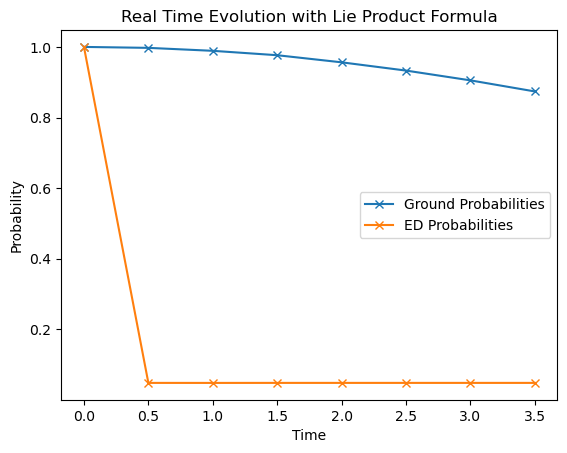

In [11]:
# Assuming ED_probs, ground_probs, and times are defined
plt.plot(times, ground_probs, marker='x', label='Ground Probabilities')
plt.plot(times, ED_probs, marker='x', label='ED Probabilities')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Real Time Evolution with Lie Product Formula')
plt.legend()  # Show legend

# Display the plot
plt.show()